# Database Integration – Weather & Bicycle Usage

This notebook writes the cleaned and merged weather and bicycle traffic data into a relational database (e.g., PostgreSQL) and queries it from Python using SQL.

## Libraries and settings

In [18]:
# Libraries
import os
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import sql
import warnings
import matplotlib.pyplot as plt

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Show current working directory
print(os.getcwd())

/workspaces/data_analytics_project/notebooks


## Starting PostgreSQL inside Codespaces

Before connecting to the database, PostgreSQL must be started in a Docker container. The project includes a `docker-compose.yml` file that configures a PostgreSQL 15 container with the following credentials:

- **Database**: postgres

- **User**: pgadmin

- **Password**: geheim

- **Port**: 5432


Run the following command in the terminal to start the container:

```bash
docker compose up -d
```

The `-d` flag starts the container in detached mode (background).

## Connecting to PostgreSQL from Python

After starting the container, we can connect to the PostgreSQL database from Python using the `psycopg2` library.

In [19]:
# Database connection parameters
conn_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'pgadmin',
    'password': 'geheim',
    'port': '5432'
}

# Establish connection
try:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor()
    
    # Test connection
    cursor.execute('SELECT version();')
    db_version = cursor.fetchone()
    
    print("Successfully connected to PostgreSQL!")
    print(f"Database version: {db_version[0][:50]}...")
    
except Exception as e:
    print(f"Error connecting to PostgreSQL: {e}")
    print("\nPlease ensure that:")
    print("1. Docker is running")
    print("2. The container is running (docker compose up -d db pgadmin)")
    print("3. Port 5432 is not already in use")

Successfully connected to PostgreSQL!
Database version: PostgreSQL 15.15 (Debian 15.15-1.pgdg13+1) on x86_...


## Creating database tables

We create a table `bikes_weather` to store all relevant information from the merged dataset.
The `time` column is used as the primary key.

In [20]:
# SQL statement to create table
create_table_query = """
CREATE TABLE IF NOT EXISTS bikes_weather (
    date DATE PRIMARY KEY,
    temp_mean FLOAT,
    humidity_mean FLOAT,
    wind_speed_mean FLOAT,
    precipitation_sum FLOAT,
    velo_in FLOAT,
    velo_out FLOAT,
    bike_count INT
);
"""

try:
    # Execute table creation
    cursor.execute(create_table_query)
    conn.commit()
    print("Table 'bikes_weather' created successfully!")
    
    # Verify table creation
    cursor.execute("""
        SELECT column_name, data_type 
        FROM information_schema.columns 
        WHERE table_name = 'bikes_weather'
        ORDER BY ordinal_position;
    """)
    
    columns = cursor.fetchall()
    print("\nTable structure:")
    for col in columns:
        print(f"  {col[0]}: {col[1]}")
        
except Exception as e:
    print(f"Error creating table: {e}")
    conn.rollback()

Table 'bikes_weather' created successfully!

Table structure:
  date: date
  temp_mean: double precision
  humidity_mean: double precision
  wind_speed_mean: double precision
  precipitation_sum: double precision
  velo_in: double precision
  velo_out: double precision
  bike_count: integer


## Loading the merged dataset

We load the preprocessed and merged dataset from Notebook 2.

In [21]:
# Load the merged dataset (daily mean temperature)
df = pd.read_csv('../data/merged_weather_bikes.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create bike_count column if not present
if 'bike_count' not in df.columns:
    df['bike_count'] = df['VELO_IN'] + df['VELO_OUT']

# Round bike_count to integer
df['bike_count'] = df['bike_count'].round().astype(int)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Dataset loaded: 359 rows, 10 columns

First 5 rows:
        date  temp_mean  humidity_mean  wind_speed_mean  precipitation_sum  \
0 2025-01-01   0.650000      86.083333         4.750000                0.0   
1 2025-01-02   3.141667      76.958333        12.662500               14.5   
2 2025-01-03  -0.308333      87.333333         5.908333                1.4   
3 2025-01-04  -1.900000      80.916667         3.183333                0.6   
4 2025-01-05   1.845833      93.000000         4.608333               15.0   

   VELO_IN  VELO_OUT  FUSS_IN  FUSS_OUT  bike_count  
0   5094.0    2558.0   1188.0    1099.0        7652  
1   5086.0    2423.0    541.0     448.0        7509  
2   9073.0    4420.0    450.0     404.0       13493  
3   7129.0    3551.0    457.0     388.0       10680  
4   5000.0    2641.0    630.0     565.0        7641  

Data types:
date                 datetime64[ns]
temp_mean                   float64
humidity_mean               float64
wind_speed_mean             float6

## Inserting the merged dataset into PostgreSQL

We insert all records into the PostgreSQL database. The `ON CONFLICT` clause prevents errors for already existing entries.

In [22]:
# Insert query with ON CONFLICT handling
insert_query = """
INSERT INTO bikes_weather (date, temp_mean, humidity_mean, wind_speed_mean, precipitation_sum, velo_in, velo_out, bike_count)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
ON CONFLICT (date) DO NOTHING;
"""

try:
    # Insert all rows
    inserted_count = 0
    
    for idx, row in df.iterrows():
        cursor.execute(insert_query, (
            row['date'],
            float(row['temp_mean']),
            float(row['humidity_mean']),
            float(row['wind_speed_mean']),
            float(row['precipitation_sum']),
            float(row['VELO_IN']) if pd.notna(row['VELO_IN']) else 0.0,
            float(row['VELO_OUT']) if pd.notna(row['VELO_OUT']) else 0.0,
            int(row['bike_count'])
        ))
        inserted_count += 1
        
        # Progress indicator
        if inserted_count % 1000 == 0:
            print(f"Inserted {inserted_count} rows...")
    
    # Commit all inserts
    conn.commit()
    print(f"\nSuccessfully inserted {inserted_count} rows into the database!")
    
    # Verify insertion
    cursor.execute("SELECT COUNT(*) FROM bikes_weather;")
    count = cursor.fetchone()[0]
    print(f"Total rows in database: {count}")
    
except Exception as e:
    print(f"Error inserting data: {e}")
    conn.rollback()


Successfully inserted 359 rows into the database!
Total rows in database: 359


## Running SQL queries on PostgreSQL

Now we can run SQL queries directly on the database and analyze the results with Pandas.

In [23]:
# Query 1: First 10 records
query1 = "SELECT * FROM bikes_weather LIMIT 10;"
result1 = pd.read_sql(query1, conn)

print("Query 1: First 10 records")
print("="*80)
print(result1)
print()

Query 1: First 10 records
         date  temp_mean  humidity_mean  wind_speed_mean  precipitation_sum  \
0  2025-01-01   0.650000      86.083333         4.750000                0.0   
1  2025-01-02   3.141667      76.958333        12.662500               14.5   
2  2025-01-03  -0.308333      87.333333         5.908333                1.4   
3  2025-01-04  -1.900000      80.916667         3.183333                0.6   
4  2025-01-05   1.845833      93.000000         4.608333               15.0   
5  2025-01-06   4.954167      80.375000         6.804167                6.9   
6  2025-01-07   3.925000      81.583333        13.595833                2.4   
7  2025-01-08   3.125000      91.666667         6.200000               11.4   
8  2025-01-09   4.616667      86.750000        12.654167               11.6   
9  2025-01-10   0.662500      81.833333         4.116667                0.1   

   velo_in  velo_out  bike_count  
0   5094.0    2558.0        7652  
1   5086.0    2423.0        7509  

In [24]:
# Query 2: Select specific columns
query2 = """
SELECT date, temp_mean, humidity_mean, precipitation_sum, bike_count 
FROM bikes_weather 
ORDER BY bike_count DESC 
LIMIT 15;
"""
result2 = pd.read_sql(query2, conn)

print("Query 2: Top 15 days by bicycle usage")
print("="*80)
print(result2)
print()

Query 2: Top 15 days by bicycle usage
          date  temp_mean  humidity_mean  precipitation_sum  bike_count
0   2025-06-19  22.837500      61.750000                0.0       70577
1   2025-08-19  21.191667      71.833333                0.0       70002
2   2025-06-24  23.133333      54.125000                0.0       67378
3   2025-06-18  20.491667      65.833333                0.0       67325
4   2025-06-12  21.150000      70.000000                0.0       67198
5   2025-06-25  25.500000      52.375000                0.0       66904
6   2025-07-10  17.320833      66.000000                0.0       66669
7   2025-06-17  19.208333      64.500000                0.0       66364
8   2025-07-02  26.737500      60.333333                0.0       65613
9   2025-06-13  23.945833      68.708333                0.0       64765
10  2025-06-11  19.133333      68.625000                0.0       64684
11  2025-07-03  24.091667      67.583333                0.3       63076
12  2025-08-14  25.183333 

In [25]:
# Query 3: Aggregate statistics
query3 = """
SELECT 
    ROUND(AVG(temp_mean)::numeric, 2) as avg_temp_mean,
    ROUND(AVG(humidity_mean)::numeric, 2) as avg_humidity,
    ROUND(AVG(wind_speed_mean)::numeric, 2) as avg_wind_speed,
    ROUND(AVG(precipitation_sum)::numeric, 2) as avg_precipitation,
    ROUND(AVG(velo_in)::numeric, 2) as avg_velo_in,
    ROUND(AVG(velo_out)::numeric, 2) as avg_velo_out,
    ROUND(AVG(bike_count)::numeric, 2) as avg_bike_count,
    MAX(bike_count) as max_bike_count,
    MIN(bike_count) as min_bike_count
FROM bikes_weather;
"""
result3 = pd.read_sql(query3, conn)

print("Query 3: Statistical summary from database")
print("="*80)
print(result3)
print()

Query 3: Statistical summary from database
   avg_temp_mean  avg_humidity  avg_wind_speed  avg_precipitation  \
0          10.58         81.15            5.49               3.53   

   avg_velo_in  avg_velo_out  avg_bike_count  max_bike_count  min_bike_count  
0     23350.49      11717.41         35067.9           70577            2614  



In [26]:
# Query 4: Weather conditions on high-traffic days
query4 = """
SELECT 
    date,
    temp_mean,
    humidity_mean,
    wind_speed_mean,
    precipitation_sum,
    velo_in,
    velo_out,
    bike_count
FROM bikes_weather
WHERE bike_count > 40000
ORDER BY bike_count DESC;
"""
result4 = pd.read_sql(query4, conn)

print(f"Query 4: High-traffic periods (bike_count > 40000)")
print("="*80)
print(f"Found {len(result4)} high-traffic days")
print(result4.head(10))
print()

Query 4: High-traffic periods (bike_count > 40000)
Found 122 high-traffic days
         date  temp_mean  humidity_mean  wind_speed_mean  precipitation_sum  \
0  2025-06-19  22.837500      61.750000         6.154167                0.0   
1  2025-08-19  21.191667      71.833333         3.825000                0.0   
2  2025-06-24  23.133333      54.125000         5.941667                0.0   
3  2025-06-18  20.491667      65.833333         2.216667                0.0   
4  2025-06-12  21.150000      70.000000         2.829167                0.0   
5  2025-06-25  25.500000      52.375000         3.829167                0.0   
6  2025-07-10  17.320833      66.000000         4.741667                0.0   
7  2025-06-17  19.208333      64.500000         9.816667                0.0   
8  2025-07-02  26.737500      60.333333         3.862500                0.0   
9  2025-06-13  23.945833      68.708333         3.245833                0.0   

   velo_in  velo_out  bike_count  
0  47470.0   231

## Example visualization from SQL result

We visualize the relationship between mean temperature and bicycle usage based on the data from the PostgreSQL database.

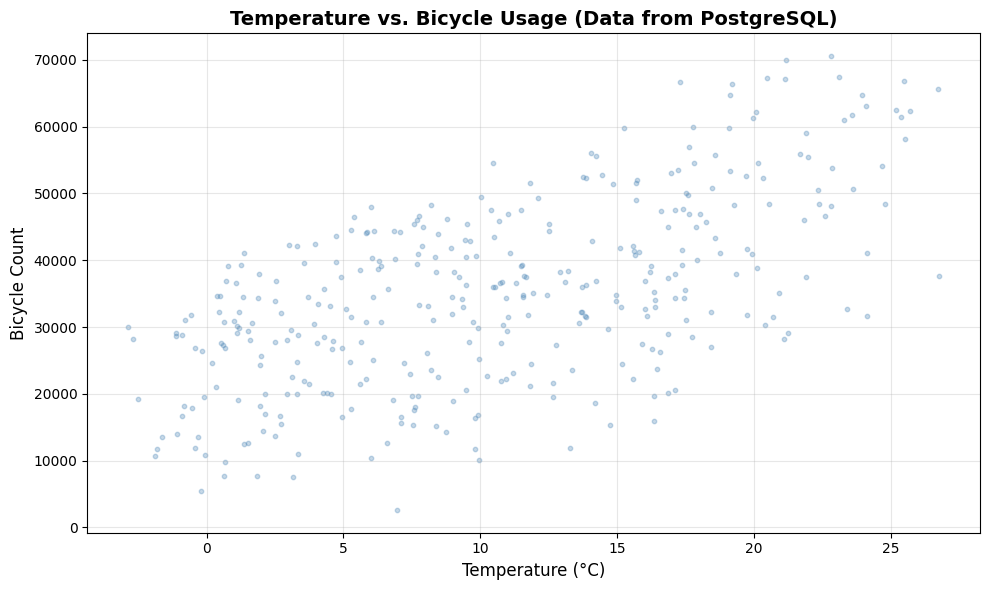

Visualized 359 data points from PostgreSQL database


In [27]:
# Re-establish database connection if closed
if conn.closed:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor()

# Query data for visualization
viz_query = """
SELECT temp_mean, bike_count
FROM bikes_weather
WHERE temp_mean IS NOT NULL
  AND bike_count IS NOT NULL;
"""

viz_df = pd.read_sql(viz_query, conn)


# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    viz_df["temp_mean"],
    viz_df["bike_count"],
    alpha=0.3,
    s=10,
    color="steelblue"
)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Bicycle Count", fontsize=12)
plt.title(
    "Temperature vs. Bicycle Usage (Data from PostgreSQL)",
    fontsize=14,
    fontweight="bold"
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Visualized {len(viz_df)} data points from PostgreSQL database")


## Conclusions

In this notebook, a PostgreSQL database integration for the Weather & Bicycle Usage project was successfully implemented:

**Achievements:**

- ✅ Configured and started PostgreSQL 15 container via Docker Compose

- ✅ Connected to the database using `psycopg2`

- ✅ Created the `bikes_weather` table with the correct schema

- ✅ Inserted daily records from the merged dataset into the database

- ✅ Performed various SQL queries (SELECT, WHERE, ORDER BY, aggregations)

- ✅ Analyzed and visualized results with Pandas


**Advantages of database integration:**

- Professional data management with a relational database

- Efficient queries with SQL instead of Pandas operations

- Scalability for larger datasets

- Persistent data storage independent of CSV files

- Multi-user capability and transaction safety


**Next steps:**

- Add indexes for performance optimization

- Implement more complex joins with multiple tables

- Automate data updates via cron jobs

- Integrate with visualization dashboards (e.g., Grafana)

In [28]:
# Close database connection
cursor.close()
conn.close()
print("Database connection closed.")

Database connection closed.


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [29]:
import os
import platform
import socket
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', platform.python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2026-01-03 07:52:19
Python Version: 3.12.1
-----------------------------------
